In [24]:
import torch
from IPython import display #用于在Jupyter Notebook中显示图像或其他内容
from d2l import torch as d2l
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [25]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size = (num_inputs, num_outputs), requires_grad = True)
b = torch.zeros(num_outputs, requires_grad = True)

In [26]:
X = torch.tensor([[0.1, 0.2, 0.6], [0.3, 0.2, 0.6]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)#按列求和,按行求和

(tensor([[0.4000, 0.4000, 1.2000]]),
 tensor([[0.9000],
         [1.1000]]))

In [27]:
def softmax(X):
    """定义softmax方法"""
    X_exp = torch.exp(X)# 对输入X的每个元素求指数
    partition = X_exp.sum(1, keepdim=True)# 在维度1上求和（通常是特征的维度），并保持结果的维度不变，用于后续广播
    return X_exp / partition# 这里应用了广播机制

In [28]:
X = torch.normal(0, 1, (2, 5))
X_softmax = softmax(X)
X_prob = X_softmax.sum(1, keepdim=True) 
X_softmax, X_prob

(tensor([[0.2004, 0.1941, 0.4302, 0.1077, 0.0676],
         [0.4978, 0.0636, 0.0687, 0.1061, 0.2638]]),
 tensor([[1.0000],
         [1.0000]]))

In [29]:
#定义模型
def net(X): 
    # 首先，对输入X进行重塑，以确保它可以与权重矩阵W进行矩阵乘法。
    # X.reshape((-1, W.shape[0]))将X重塑为一个二维张量，其第二维的大小与W的第一维（特征数量）相同。
    # -1在这里表示自动计算该维度的大小，以便保持元素总数不变。
    # 然后，使用torch.matmul进行矩阵乘法，将输入X（经过重塑）与权重矩阵W相乘。
    # 加上偏置b（假设b已经是一个合适的形状，通常是一个一维张量，其长度与输出特征的数量相同）。
    # 最后，应用softmax函数将结果转换为概率分布。
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [30]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y],len(y_hat)
"""
这行代码使用了高级索引（fancy indexing）来从y_hat张量中选择特定的元素。这里发生了两件事情：
[0, 1]指定了y_hat的第一维（行）的索引。这意味着我们将从第一行和第二行中选择元素。
y（即[0, 2]）指定了对应于这些行的第二维（列）的索引。因此，我们从第一行选择索引为0的列的元素（即0.1），从第二行选择索引为2的列的元素（即0.5）。
结果是一个一维张量，包含了根据y中指定的类别索引从y_hat中选择的预测概率值。在这个例子中，输出将是tensor([0.1000, 0.5000])
"""


'\n这行代码使用了高级索引（fancy indexing）来从y_hat张量中选择特定的元素。这里发生了两件事情：\n[0, 1]指定了y_hat的第一维（行）的索引。这意味着我们将从第一行和第二行中选择元素。\ny（即[0, 2]）指定了对应于这些行的第二维（列）的索引。因此，我们从第一行选择索引为0的列的元素（即0.1），从第二行选择索引为2的列的元素（即0.5）。\n结果是一个一维张量，包含了根据y中指定的类别索引从y_hat中选择的预测概率值。在这个例子中，输出将是tensor([0.1000, 0.5000])\n'

In [32]:
#定义损失函数
def cross_entropy(y_hat, y): 
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [33]:
def accuracy(y_hat, y): #@%save
    if len(y_hat.shape) >1 and y_hat.shape[1]>1 :
        y_hat = y_hat.argmax(axis=1)
        #如果满足上述条件，这行代码将y_hat沿着第一个轴（axis=1，即类别的维度）进行argmax操作，这意味着它会返回每个样本最可能属于的类别的索引
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())
    #计算所有True值的总和（即预测正确的数量），最后将这个总数转换为浮点数并返回

In [34]:
accuracy(y_hat, y) / len(y)

0.5

In [35]:
def evacuate_accuracy(net, data_iter): #@%save
    """制定训练集的正确率"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2)  #创建了一个Accumulator实例，用于累加两个值：正确预测的数量和总预测数量
    with torch.no_grad(): 
        for X, y in data_iter: 
            metric.add(accuracy(net(X), y), y.numel())
            #首先通过模型net对输入X进行预测，然后调用accuracy函数计算预测正确的数量，y.numel()返回标签y中元素的总数
    return metric[0] / metric[1] 

In [36]:
#实现累加
class Accumulator:  #@%save
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args): 
        self.data = [a + float(b) for a,b in zip(self.data, args)]

    def reset(self): 
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx): 
        return self.data[idx]

In [37]:
evacuate_accuracy(net, test_iter)

0.2281

In [38]:
#训练模型
def train_epoch_ch3(net, train_iter, loss, updater): #@%save
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    #累加训练损失总和、训练准确度总和以及样本数
    for X,y in train_iter: 
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer): 
            # 使用PyTorch内置的优化器和损失函数——updater
            updater.zero_grab()
            l.mean.backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]
    #函数通过计算metric[0] / metric[2]（总损失除以总样本数）和metric[1] / metric[2]（总准确度除以总样本数）来得到平均训练损失和平均训练精度

In [39]:
lr = 0.1
#定义优化函数
def updator(batch_size): 
    return d2l.sgd([W, b], lr, batch_size)
"""
SGD可以参考以下代码
def sgd(params, lr, batch_size):  #@save
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
"""

'\nSGD可以参考以下代码\ndef sgd(params, lr, batch_size):  #@save\n    with torch.no_grad():\n        for param in params:\n            param -= lr * param.grad / batch_size\n            param.grad.zero_()\n'

In [40]:
#动态作图
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(7, 5)):
        # 增量地绘制多条线
        if legend is None: 
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize = figsize)
        if nrows * ncols ==1: 
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(    #用于配置轴（如标签、范围、刻度等），并捕获相关参数
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
        #self.fmts被初始化为传入的fmts参数，即线条的格式

    def add(self, x, y): 
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"): 
            x = [x] * n
        if not self.X: 
            self.X = [[] for _ in range(n)]
        if not self.Y: 
            self.Y = [[] for _ in range(n)]
        #如果self.X和self.Y还未被初始化，则分别创建长度为n的列表，
        #其中每个元素都是一个空列表。这些空列表将用于存储每条线条的x和y数据点
        for i, (a, b) in enumerate(zip(x ,y)): 
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
            #遍历x和y中的数据对，如果数据对中的元素都不是None，则将它们分别添加到对应线条的self.X[i]和self.Y[i]中
        self.axes[0].cla() 
        #调用cla方法清空当前轴的内容，准备绘制新的线条
        for x, y, fmt in zip(self.X, self.Y, self.fmts): 
            self.axes[0].plot(x, y, fmt)
        #遍历存储的数据点和线条格式，使用plot方法在轴上绘制每条线条
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
        #使用display.display显示图形，然后调用display.clear_output(wait=True)清除之前的输出

In [41]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updator): #@%save
    """训练模型（定义见第3章）"""
    """
    net: 要训练的神经网络模型。
    train_iter: 训练数据的迭代器，用于按批次提供训练数据。
    test_iter: 测试数据的迭代器，用于评估模型的性能。
    loss: 损失函数，用于计算模型预测与实际标签之间的差异。
    num_epochs: 训练的轮数，即整个训练数据集被遍历的次数。
    updater: 更新器，用于更新模型的参数，通常是一个优化算法，如SGD（随机梯度下降）
    """
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs): 
        train_metrics = train_epoch_ch3(net, train_iter, loss, updator)
        test_acc = evacuate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    #使用assert语句来验证训练损失是否小于0.5。如果不是，程序将抛出一个AssertionError，并显示训练损失的值
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    #使用assert语句来验证训练准确率是否在0.7到1之间（包括0.7但不包括1的极限情况，但由于浮点数的精度问题，实际上可能接近1）。
    #如果不是，程序将抛出一个AssertionError，并显示训练准确率的值
    assert test_acc <= 1 and test_acc > 0.7, test_acc
    #使用assert语句来验证测试准确率是否在0.7到1之间。与训练准确率相同，这里也有关于浮点数精度的隐含考虑

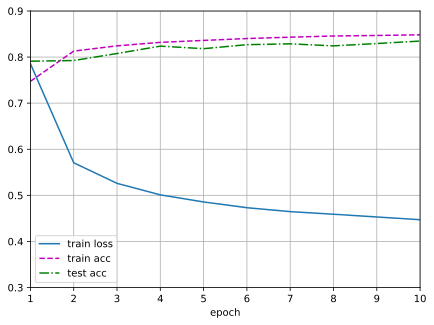

In [42]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updator)

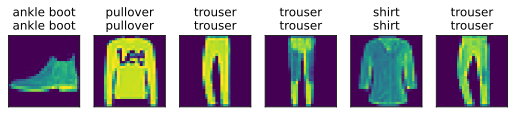

In [43]:
"""预测标签（定义见第3章）"""
def pred_ch3(net, test_iter, n=6): #@%save
    for X,y in test_iter: 
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

pred_ch3(net, test_iter)